In [220]:
import os
import time
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pickle
from copy import deepcopy

from data_preprocessing import get_all_data
from utils import f1, accuracy, split_data

RUNS_PATH = "runs"

In [221]:
def load_results(file_subpath):
    with open(os.path.join(RUNS_PATH, file_subpath), "rb") as f:
        return pickle.load(f)

In [222]:
### load results
results = load_results("2024-10-28_22-11-30/All_columns__Logistic_Regression__results.pkl")
logreg = results["Logistic Regression"]

results = load_results("2024-10-28_22-11-30/Selected_columns_+_All_columns_PCA__Logistic_Regression__results.pkl")
svm = results["SVM"]

## Plotting scores

In [223]:
### grid search results
def get_2d_hps_grid(hps, val_scores, get_hp_to_plot_1, get_hp_to_plot_2):
    uniq_1 = np.unique([get_hp_to_plot_1(hp) for hp in hps])
    uniq_2 = np.unique([get_hp_to_plot_2(hp) for hp in hps])
    grid_sum = np.zeros((len(uniq_1), len(uniq_2)))
    grid_seen_n = np.zeros((len(uniq_1), len(uniq_2)))
    for i, (hp, score) in enumerate(zip(hps, val_scores)):
        grid_sum[
            np.where(uniq_1 == get_hp_to_plot_1(hp))[0][0],
            np.where(uniq_2 == get_hp_to_plot_2(hp))[0][0]
        ] += score
        grid_seen_n[
            np.where(uniq_1 == get_hp_to_plot_1(hp))[0][0],
            np.where(uniq_2 == get_hp_to_plot_2(hp))[0][0]
        ] += 1
    assert np.all(grid_seen_n > 0)
    grid = grid_sum / grid_seen_n
    return grid, uniq_1, uniq_2

In [224]:
### prepare logreg results
hps = logreg["hyperparam_search_list"]
val_scores = logreg["all_val_scores"]
logreg_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
logreg_get_hp_to_plot_2 = lambda hps_dict: hps_dict["reg_mul"]
logreg["grid"], logreg["uniq_1"], logreg["uniq_2"] = get_2d_hps_grid(hps, val_scores, logreg_get_hp_to_plot_1, logreg_get_hp_to_plot_2)

In [225]:
### prepare svm results
hps = svm["hyperparam_search_list"]
val_scores = svm["all_val_scores"]
svm_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
svm_get_hp_to_plot_2 = lambda hps_dict: hps_dict["_lambda"]
svm["grid"], svm["uniq_1"], svm["uniq_2"] = get_2d_hps_grid(hps, val_scores, svm_get_hp_to_plot_1, svm_get_hp_to_plot_2)

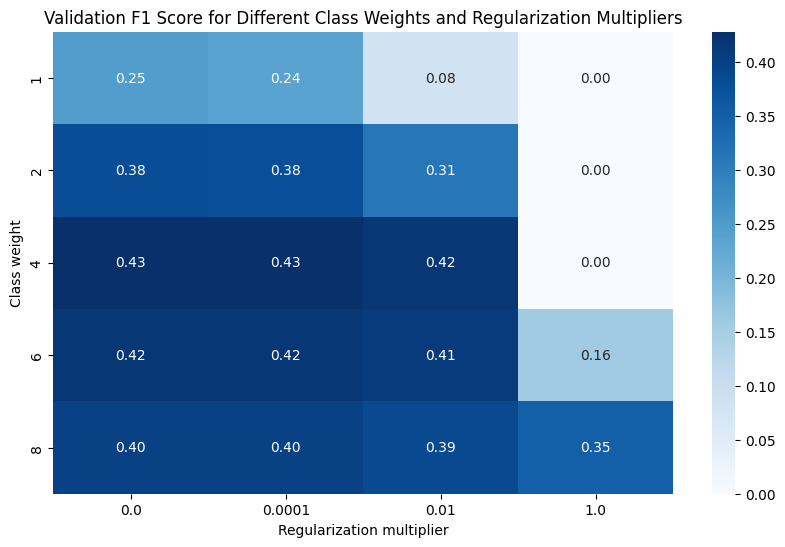

In [226]:
# Create a heatmap using Seaborn
plot_dict = logreg  # assuming you're using the logistic regression dictionary
data = plot_dict["grid"]

plt.figure(figsize=(10, 6))
sns.heatmap(
    data,
    annot=True,               # Annotate each cell with the score
    fmt=".2f",                # Format the score to 2 decimal places
    cmap="Blues",
    #cbar_kws={"label": "Validation F1 Score"},  # Label the color bar
    #linewidths=0.5,           # Add slight line separation between cells
    #linecolor="gray",         # Gray color for cell borders
    #annot_kws={"color": "white", "weight": "bold"}  # Customize annotation text style
)

# Set labels
plt.xlabel("Regularization multiplier")
plt.ylabel("Class weight")
plt.xticks(ticks=np.arange(len(plot_dict["uniq_2"])) + 0.5, labels=plot_dict["uniq_2"])
plt.yticks(ticks=np.arange(len(plot_dict["uniq_1"])) + 0.5, labels=plot_dict["uniq_1"])
plt.title("Validation F1 Score for Different Class Weights and Regularization Multipliers")

plt.show()


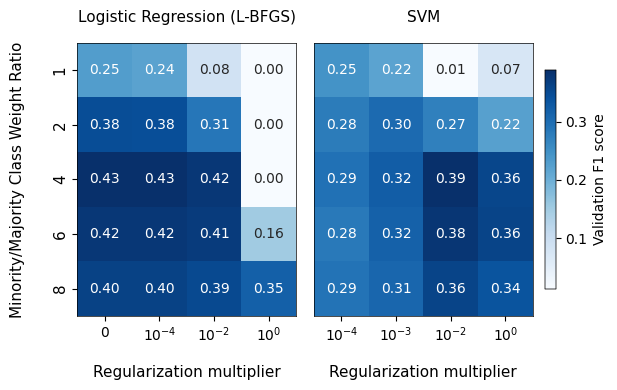

In [227]:
logreg_xtick_labels = [r"$10^{{{}}}$".format(int(np.log10(x))) if x != 0 else "0" for x in logreg["uniq_2"]]
svm_xtick_labels = [r"$10^{{{}}}$".format(int(np.log10(x))) if x != 0 else "0" for x in svm["uniq_2"]]

fontsize = 11

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# left - Logistic Regression
sns.heatmap(
    logreg["grid"],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=axs[0],
    cbar=False,
    annot_kws={"fontsize": 10},
    square=True,
)
axs[0].set_title("Logistic Regression (L-BFGS)", fontsize=fontsize, pad=15)
axs[0].set_xlabel("Regularization multiplier", fontsize=fontsize, labelpad=15)
axs[0].set_ylabel("Minority/Majority Class Weight Ratio", fontsize=fontsize, labelpad=20)
axs[0].set_xticks(np.arange(len(logreg["uniq_2"])) + 0.5)
axs[0].set_xticklabels(logreg_xtick_labels, fontsize=fontsize-1)
axs[0].set_yticks(np.arange(len(logreg["uniq_1"])) + 0.5)
axs[0].set_yticklabels(logreg["uniq_1"], fontsize=fontsize)

# Add border to the left heatmap
for spine in axs[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)  # Adjust the border thickness if needed

# right - SVM
sns.heatmap(
    svm["grid"],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=axs[1],
    cbar=True,
    cbar_kws={"shrink": 0.8, "label": "Validation F1 score", "pad": 0.01},
    annot_kws={"fontsize": 10},
    square=True,
)
axs[1].set_title("SVM", fontsize=fontsize, pad=15)
axs[1].set_xlabel("Regularization multiplier", fontsize=fontsize, labelpad=15)
axs[1].set_xticks(np.arange(len(svm["uniq_2"])) + 0.5)
axs[1].set_xticklabels(svm_xtick_labels, fontsize=fontsize-1)
axs[1].set_yticks([])
axs[1].set_yticklabels([])

# Add border to the right heatmap
for spine in axs[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)  # Adjust the border thickness if needed

# Add border to the color bar
cbar = axs[1].collections[0].colorbar
for spine in cbar.ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.3)

# Adjust layout for better spacing
fig.tight_layout()
plt.subplots_adjust(wspace=-1.06)
plt.show()

# Save as pdf
fig.savefig("hyperparam_search.pdf", bbox_inches="tight")


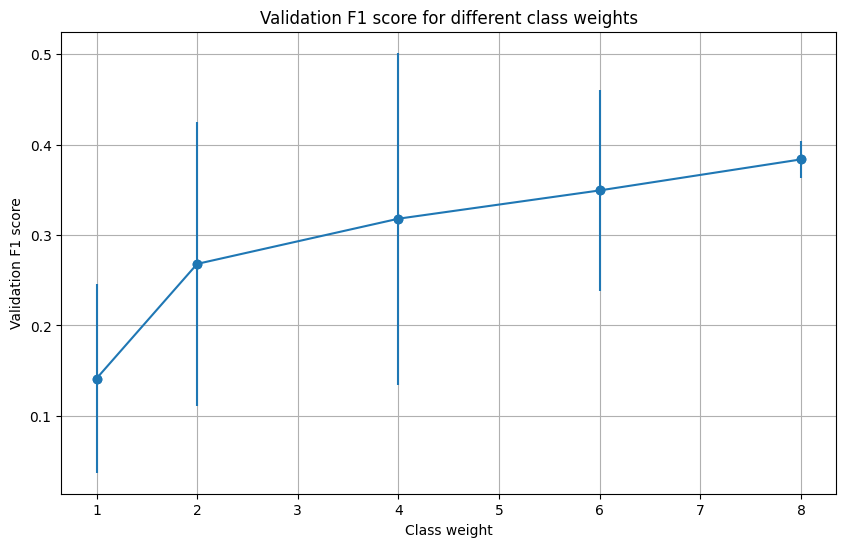

In [232]:
grid = logreg["grid"]
uniq_1 = logreg["uniq_1"]

### plot only one of the hyperparameters
hp_avg_scores = grid.mean(axis=1)
hp_std_scores = grid.std(axis=1)
assert len(hp_avg_scores) == len(uniq_1) == len(hp_std_scores)
plt.figure(figsize=(10, 6))
plt.plot(uniq_1, hp_avg_scores, marker="o", color="tab:blue")
plt.errorbar(uniq_1, hp_avg_scores, yerr=hp_std_scores, fmt="o", color="tab:blue")

# plt.plot(uniq_1, hp_avg_scores, marker="o")
# plt.fill_between(uniq_1, hp_avg_scores - hp_std_scores, hp_avg_scores + hp_std_scores, alpha=0.2)

plt.xlabel("Class weight")
plt.ylabel("Validation F1 score")
plt.title("Validation F1 score for different class weights")
plt.grid()
plt.show()

## Training analysis

In [233]:
cfg = {
    "raw_data_path": "data_raw",
    "clean_data_path": "data_clean",
    "allow_load_clean_data": False,
    "remap_labels_to_01": True,
    "seed": 0,
    "eval_frac": 0.2,
}

In [234]:
### get data
# x, x_final, y, ids, ids_final, col_idx_map, cleaned_col_idx_map = get_all_data(
#     cfg=cfg,
#     process_cols="all",
#     pca_kwargs=None,
#     verbose=False,
# )
# x_train, x_test, y_train, y_test = split_data(x=x, y=y, split_frac=0.2, seed=cfg["seed"])
(x_train, x_test), (y_train, y_test), (ids_train, ids_test), col_idx_map, cleaned_col_idx_map, (x_final, ids_final) = get_all_data(
    cfg=cfg,
    process_cols="all",
    pca_kwargs=None,
    standardize_num=True,
    onehot_cat=True,
    skip_rule_transformations=False,
    verbose=False,
)
sample_weights_train = np.array([logreg["hyperparams"]["class_weights"][yi] for yi in y_train])
sample_weights_test = np.array([logreg["hyperparams"]["class_weights"][yi] for yi in y_test])
print(f"x_train.shape: {x_train.shape}, x_test.shape: {x_test.shape}, y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")

/home/keko24/workspace/epfl/ml/project1/ml-first-project/data_preprocessing.py:303: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr)
/home/keko24/miniforge3/envs/ml_aicrowd/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


x_train.shape: (262508, 939), x_test.shape: (65627, 939), y_train.shape: (262508,), y_test.shape: (65627,)


In [235]:
# Setup param update callback
def update_callback(w, x, y, epoch, model, **kwargs):
    reg_mul_before = model.reg_mul
    model.reg_mul = 0

    # Time tracking
    current_time = time.time()
    if hasattr(update_callback, 'genesis_time'):
        time_elapsed = current_time - update_callback.genesis_time
    else:
        time_elapsed = 0  # First call, so no time elapsed
        update_callback.genesis_time = current_time

    # Save the elapsed time to history
    history["time_elapsed"].append(time_elapsed)

    ### Loss
    history["train_loss"].append(model.log_reg_loss(
        x=x_train, y=y_train, w=w, sample_weights=sample_weights_train))
    history["test_loss"].append(model.log_reg_loss(
        x=x_test, y=y_test, w=w, sample_weights=sample_weights_test))

    ### F1
    y_hat_train = model.predict(x=x_train, w=w)
    history["train_f1"].append(f1(y_train, y_hat_train))
    y_hat_test = model.predict(x=x_test, w=w)
    history["test_f1"].append(f1(y_test, y_hat_test))

    history["w"].append(deepcopy(w))
    history["epoch"].append(epoch)

    model.reg_mul = reg_mul_before

In [236]:
### make a new hyperparams dict
new_hps = deepcopy(logreg["hyperparams"])
new_hps["optim_algo"] = "gd"
new_hps["optim_kwargs"] = {'epochs': 50}
# new_hps["optim_algo"] = "sgd"
# new_hps["optim_kwargs"] = {'epochs': 3, "batch_size": 256}
# new_hps["use_line_search"] = False
# new_hps["gamma"] = 1e-2
new_hps

{'gamma': None,
 'use_line_search': True,
 'optim_algo': 'gd',
 'optim_kwargs': {'epochs': 50},
 'class_weights': {0: 1, 1: 4},
 'reg_mul': 0,
 'verbose': False}

In [237]:
### train
history = defaultdict(list) # for tracking the optimization process
model = logreg["model_cls"](update_callback=update_callback, **new_hps)
model = model.fit(x_train, y_train)

In [238]:
### save for later
#history_lbfgs = deepcopy(history)
history_gd = deepcopy(history)
# history_sgd = deepcopy(history)

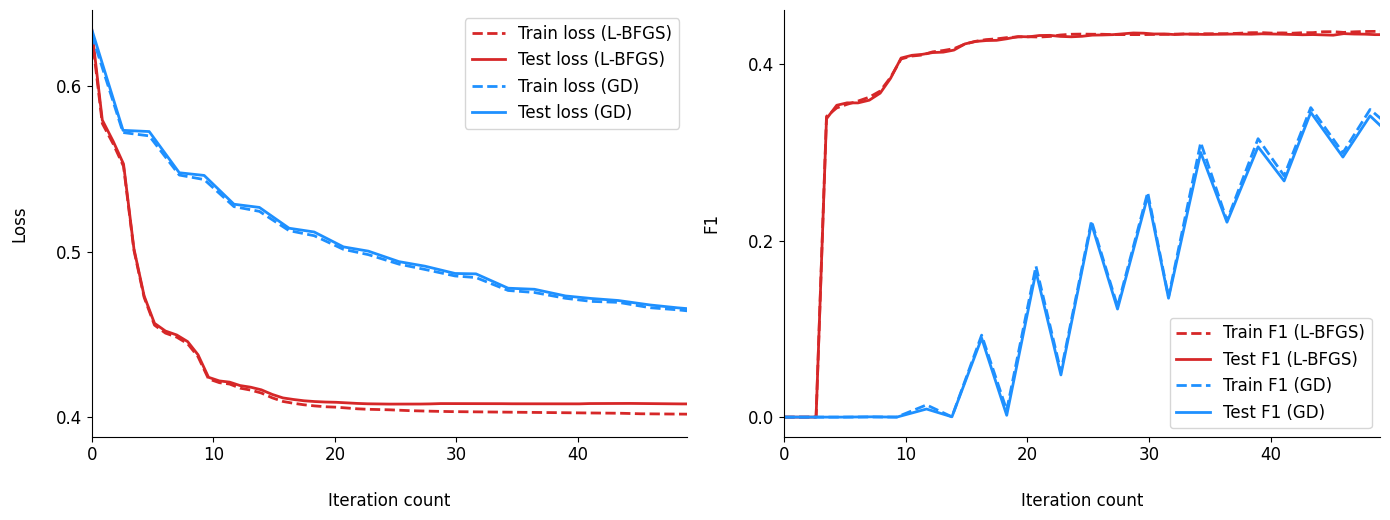

In [239]:
fontsize = 12
linewidth = 2

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5.3))

# Plot 1: Loss
ax1.plot(history_lbfgs["time_elapsed"], history_lbfgs["train_loss"], color="tab:red", linestyle="--", label="Train loss (L-BFGS)", linewidth=linewidth)
ax1.plot(history_lbfgs["time_elapsed"], history_lbfgs["test_loss"], color="tab:red", label="Test loss (L-BFGS)", linewidth=linewidth)
ax1.plot(history_gd["time_elapsed"], history_gd["train_loss"], color="dodgerblue", linestyle="--", label="Train loss (GD)", linewidth=linewidth)
ax1.plot(history_gd["time_elapsed"], history_gd["test_loss"], color="dodgerblue", label="Test loss (GD)", linewidth=linewidth)

ax1.set_xlabel("Iteration count", fontsize=fontsize, labelpad=20)
ax1.set_ylabel("Loss", fontsize=fontsize, labelpad=20)
ax1.legend(loc="upper right", fontsize=fontsize)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_yticks([.4, .5, .6])
ax1.tick_params(axis="both", which="major", labelsize=fontsize)
ax1.set_xlim(0, min(len(history_lbfgs["time_elapsed"]), len(history_gd["time_elapsed"])) - 1)

# Plot 2: F1
ax2.plot(history_lbfgs["time_elapsed"], history_lbfgs["train_f1"], color="tab:red", linestyle="--", label="Train F1 (L-BFGS)", linewidth=linewidth)
ax2.plot(history_lbfgs["time_elapsed"], history_lbfgs["test_f1"], color="tab:red", label="Test F1 (L-BFGS)", linewidth=linewidth)
ax2.plot(history_gd["time_elapsed"], history_gd["train_f1"], color="dodgerblue", linestyle="--", label="Train F1 (GD)", linewidth=linewidth)
ax2.plot(history_gd["time_elapsed"], history_gd["test_f1"], color="dodgerblue", label="Test F1 (GD)", linewidth=linewidth)

ax2.set_xlabel("Iteration count", fontsize=fontsize, labelpad=20)
ax2.set_ylabel("F1", fontsize=fontsize, labelpad=20)
ax2.legend(loc="lower right", fontsize=fontsize)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_yticks([0, .2, .4])
ax2.tick_params(axis="both", which="major", labelsize=fontsize)
ax2.set_xlim(0, min(len(history_lbfgs["time_elapsed"]), len(history_gd["time_elapsed"])) - 1)

fig.tight_layout()
fig.savefig("optim_algo_loss_f1_comparison.pdf", bbox_inches="tight")

plt.show()


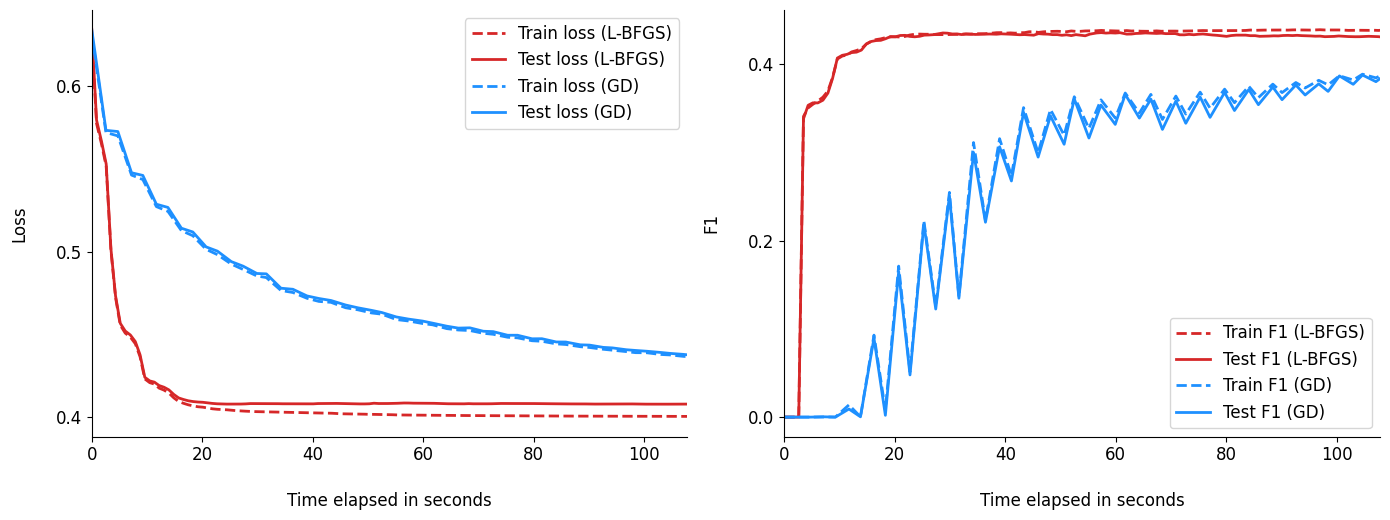

In [240]:
import matplotlib.pyplot as plt

fontsize = 12
linewidth = 2

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5.3))

# Plot 1: Loss
ax1.plot(history_lbfgs["time_elapsed"], history_lbfgs["train_loss"], color="tab:red", linestyle="--", label="Train loss (L-BFGS)", linewidth=linewidth)
ax1.plot(history_lbfgs["time_elapsed"], history_lbfgs["test_loss"], color="tab:red", label="Test loss (L-BFGS)", linewidth=linewidth)
ax1.plot(history_gd["time_elapsed"], history_gd["train_loss"], color="dodgerblue", linestyle="--", label="Train loss (GD)", linewidth=linewidth)
ax1.plot(history_gd["time_elapsed"], history_gd["test_loss"], color="dodgerblue", label="Test loss (GD)", linewidth=linewidth)

ax1.set_xlabel("Time elapsed in seconds", fontsize=fontsize, labelpad=20)
ax1.set_ylabel("Loss", fontsize=fontsize, labelpad=20)
ax1.legend(loc="upper right", fontsize=fontsize)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_yticks([.4, .5, .6])
ax1.tick_params(axis="both", which="major", labelsize=fontsize)
ax1.set_xlim(0, min(history_lbfgs["time_elapsed"][-1], history_gd["time_elapsed"][-1]) - 1)

# Plot 2: F1
ax2.plot(history_lbfgs["time_elapsed"], history_lbfgs["train_f1"], color="tab:red", linestyle="--", label="Train F1 (L-BFGS)", linewidth=linewidth)
ax2.plot(history_lbfgs["time_elapsed"], history_lbfgs["test_f1"], color="tab:red", label="Test F1 (L-BFGS)", linewidth=linewidth)
ax2.plot(history_gd["time_elapsed"], history_gd["train_f1"], color="dodgerblue", linestyle="--", label="Train F1 (GD)", linewidth=linewidth)
ax2.plot(history_gd["time_elapsed"], history_gd["test_f1"], color="dodgerblue", label="Test F1 (GD)", linewidth=linewidth)

ax2.set_xlabel("Time elapsed in seconds", fontsize=fontsize, labelpad=20)
ax2.set_ylabel("F1", fontsize=fontsize, labelpad=20)
ax2.legend(loc="lower right", fontsize=fontsize)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_yticks([0, .2, .4])
ax2.tick_params(axis="both", which="major", labelsize=fontsize)
ax2.set_xlim(0, min(history_lbfgs["time_elapsed"][-1], history_gd["time_elapsed"][-1]) - 1)

fig.tight_layout()
fig.savefig("optim_algo_loss_f1_comparison.pdf", bbox_inches="tight")

plt.show()


In [ ]:
with open("history_sgd.pkl", "wb") as f:
    pickle.dump(history_sgd, f)

In [ ]:
# y_hat = results["Logistic Regression"]["model"].predict(x)
y_hat = model.predict(x)

In [ ]:
f1(y, y_hat), accuracy(y, y_hat)

## Model interpretation

In [ ]:
w = model.w

### get the most important features
top_k = 10
top_k_idx = np.argsort(np.abs(w))[::-1][:top_k]
top_k_idx, w[top_k_idx]

### ...